In [77]:
# import class for web scraping
import requests
from bs4 import BeautifulSoup

# import class for financial data
import yfinance as yf

# import class for data manipulation and analysis
import pandas as pd
import numpy as np

# import class for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import class for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS


# import class for evaluation metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# import class for formalized statisitcial tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint

# import class for connection to broker 
from ib_insync import *
import nest_asyncio

# import class(s) for supportive functions
import random
import datetime as dt


In [79]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raise an exception for HTTP errors
    html_content = response.text  # Print the HTML content of the page
    soup = BeautifulSoup(html_content, 'html.parser')
    tables = pd.read_html(str(soup))
    df = tables[0]
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching URL: {e}")

/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_36582/3970819978.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(str(soup))


In [80]:
df[df['GICS Sub-Industry'] == 'Semiconductors']

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors,"Santa Clara, California",2017-03-20,2488,1969
34,ADI,Analog Devices,Information Technology,Semiconductors,"Wilmington, Massachusetts",1999-10-12,6281,1965
71,AVGO,Broadcom,Information Technology,Semiconductors,"Palo Alto, California",2014-05-08,1730168,1961
196,FSLR,First Solar,Information Technology,Semiconductors,"Tempe, Arizona",2022-12-19,1274494,1999
249,INTC,Intel,Information Technology,Semiconductors,"Santa Clara, California",1976-12-31,50863,1968
315,MCHP,Microchip Technology,Information Technology,Semiconductors,"Chandler, Arizona",2007-09-07,827054,1989
316,MU,Micron Technology,Information Technology,Semiconductors,"Boise, Idaho",1994-09-27,723125,1978
324,MPWR,Monolithic Power Systems,Information Technology,Semiconductors,"Kirkland, Washington",2021-02-12,1280452,1997
347,NVDA,Nvidia,Information Technology,Semiconductors,"Santa Clara, California",2001-11-30,1045810,1993
349,NXPI,NXP Semiconductors,Information Technology,Semiconductors,"Eindhoven, Netherlands",2021-03-22,1413447,1953


In [81]:
tickers_list = df[df['GICS Sub-Industry'] == 'Semiconductors']['Symbol'].tolist()
tickers_list

['AMD',
 'ADI',
 'AVGO',
 'FSLR',
 'INTC',
 'MCHP',
 'MU',
 'MPWR',
 'NVDA',
 'NXPI',
 'ON',
 'QCOM',
 'SWKS',
 'TXN']

In [82]:
current_date = dt.datetime.now().strftime('%Y-%m-%d')
df = yf.download(tickers_list, start = '2020-01-01', end = current_date)['Close']
df.head()

[*********************100%***********************]  14 of 14 completed


Ticker,ADI,AMD,AVGO,FSLR,INTC,MCHP,MPWR,MU,NVDA,NXPI,ON,QCOM,SWKS,TXN
Date,,,,,,,,,,,,,,
2020-01-02,108.511063,49.099998,27.836233,57.240002,53.666466,48.412537,172.722168,54.099537,5.971747,117.315430,25.059999,78.043144,106.546440,110.170677
2020-01-03,106.600883,48.599998,27.128223,57.020000,53.013718,47.350700,169.594086,53.259571,5.876163,116.183723,24.690001,76.573601,103.901840,108.708191
2020-01-06,105.348465,48.389999,27.087635,55.830002,52.863770,46.671314,167.857376,52.321949,5.900805,115.362320,24.070000,76.124832,102.071594,107.951439
2020-01-07,107.745209,48.250000,26.994387,56.669998,51.981678,49.802837,169.421402,56.912449,5.972245,116.859093,24.660000,78.289505,103.043640,110.034653
2020-01-08,108.718307,47.830002,26.657648,56.700001,52.016956,49.172920,169.200699,56.179909,5.983446,117.151146,24.820000,78.060730,104.681183,110.332237


In [83]:
def cointegration_pairs(df, threshold=0.05):
    pairs = []
    for i in range(len(df.columns)):
        for j in range(i + 1, len(df.columns)):
            stock1 = df.iloc[:, i]
            stock2 = df.iloc[:, j]
            score, p_value, _ = coint(stock1, stock2)
            if p_value < threshold:
                pairs.append((df.columns[i], df.columns[j], p_value))
    return pairs

In [84]:
list_of_pairs = cointegration_pairs(df, threshold=0.05)
sorted_pairs = sorted(list_of_pairs, key=lambda x: x[2])
for pair in sorted_pairs:
    print(f"Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.4f}")
    pvalues = [pair[2] for pair in sorted_pairs]

Stock 1: ADI, Stock 2: MPWR, p-value: 0.0070
Stock 1: MPWR, Stock 2: MU, p-value: 0.0194
Stock 1: AMD, Stock 2: MU, p-value: 0.0296


In [85]:
lowest_p_val = sorted_pairs[-1][0:2]
lowest_p_val

('AMD', 'MU')

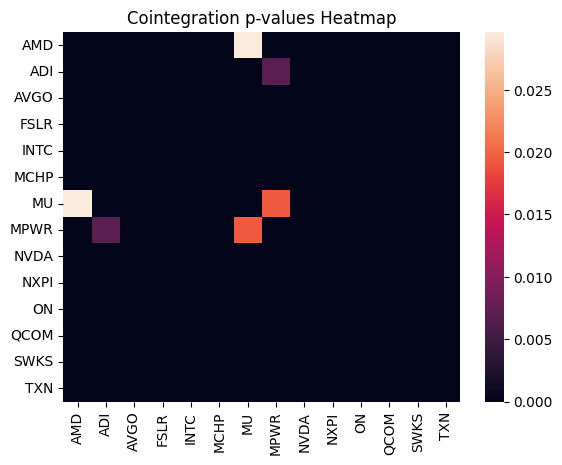

In [86]:
# Create a matrix of p-values
pvalues_matrix = np.zeros((len(tickers_list), len(tickers_list)))
for pair in sorted_pairs:
    i = tickers_list.index(pair[0])
    j = tickers_list.index(pair[1])
    pvalues_matrix[i, j] = pair[2]
    pvalues_matrix[j, i] = pair[2]  # Mirror the values

# Create heatmap
sns.heatmap(
    pvalues_matrix,
    xticklabels=tickers_list,
    yticklabels=tickers_list,
    mask=(pvalues_matrix > 0.10)
)
plt.title('Cointegration p-values Heatmap')
plt.show()

In [87]:
stock1 = df[f'{lowest_p_val[0]}']
stock2 = df[f'{lowest_p_val[1]}']

In [88]:
results = sm.OLS(stock2, stock1).fit()
b = results.params[0]
spread = stock2 - b * stock1

/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_36582/2601335917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = results.params[0]


In [89]:
hedge_ratio = results.params[0]
print('Hedge Ratio = ', hedge_ratio)

Hedge Ratio =  0.6983340235995512


/var/folders/dl/q12jywhx4svgdkc33pp48gq80000gn/T/ipykernel_36582/2668187976.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = results.params[0]


In [90]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     MU   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          3.791e+04
Date:                Fri, 05 Sep 2025   Prob (F-statistic):                        0.00
Time:                        13:16:58   Log-Likelihood:                         -5899.6
No. Observations:                1426   AIC:                                  1.180e+04
Df Residuals:                    1425   BIC:                                  1.181e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AMD            0.6983      0.004    194.713      0.000       0.691       0.705
==============================================================================
Omnibus:                       37.302   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.875
Skew:                          -0.326   Prob(JB):                     1.80e-10
Kurtosis:                       3.574   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

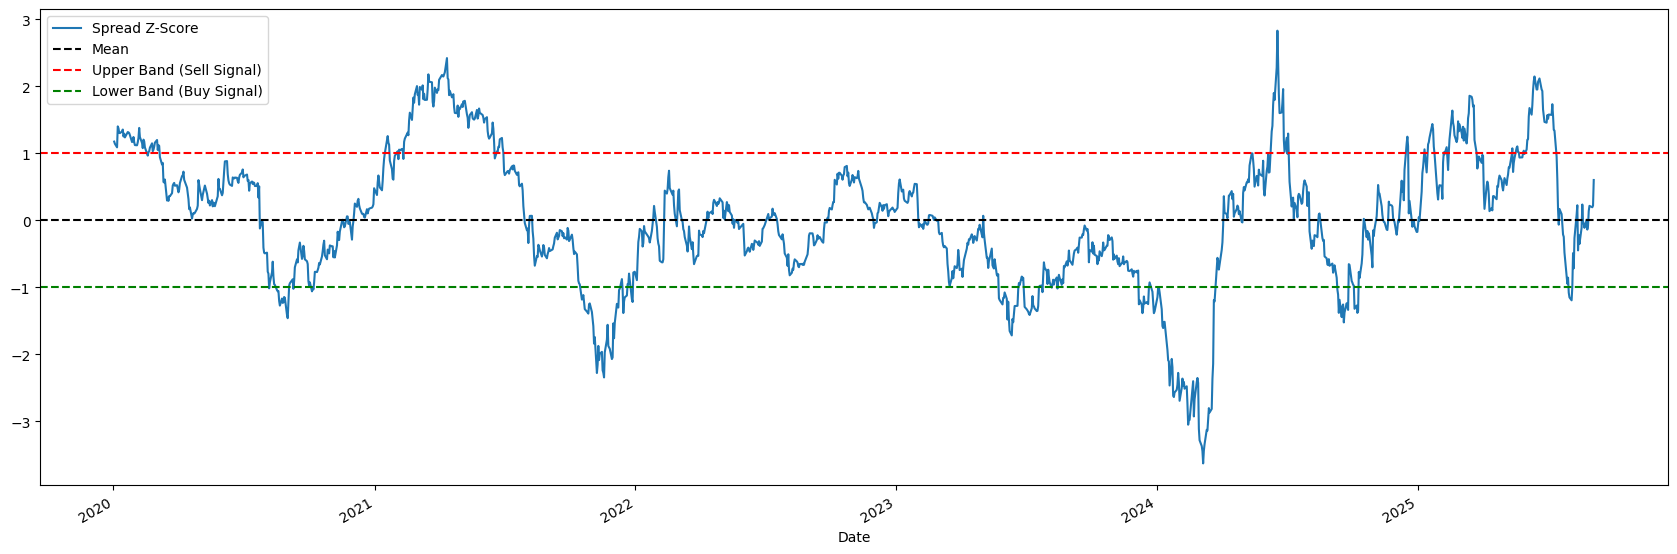

In [92]:
zscore(spread).plot(figsize=(21,7))
plt.axhline(zscore(spread).mean(), color='black', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread Z-Score', 'Mean', 'Upper Band (Sell Signal)', 'Lower Band (Buy Signal)'])

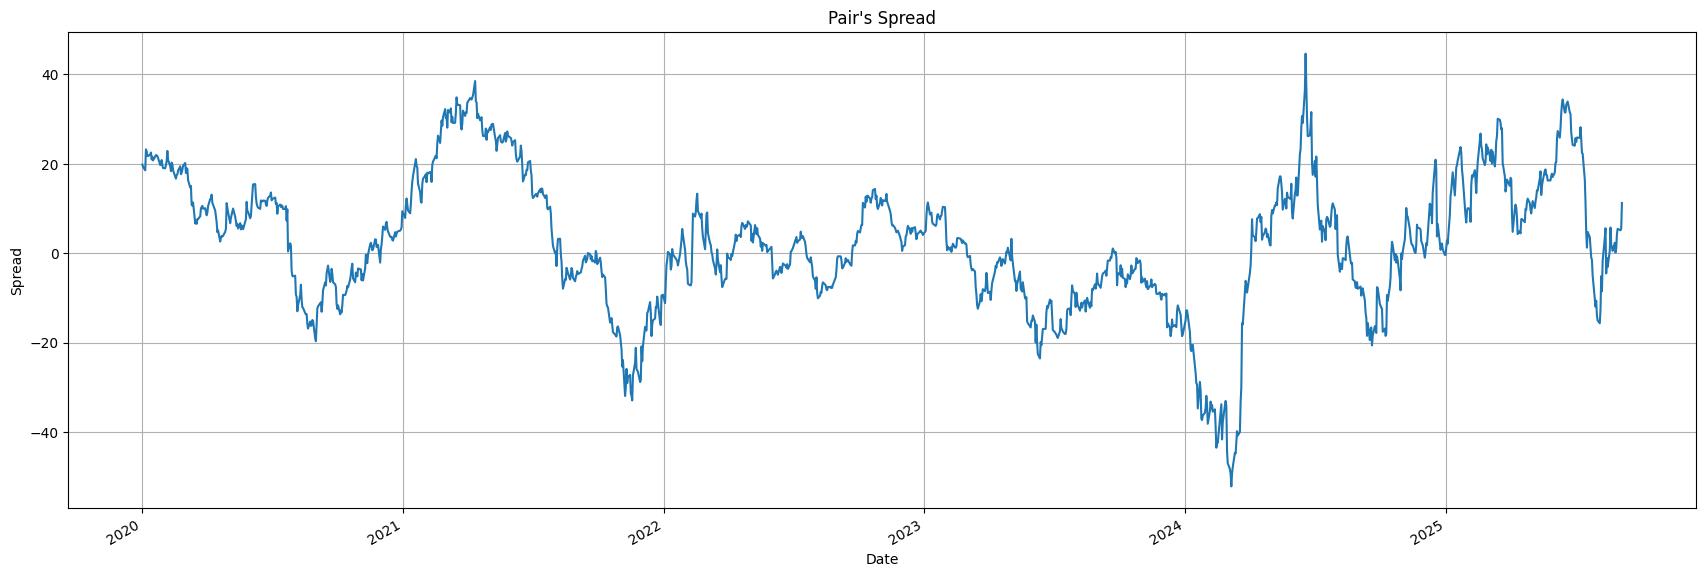

In [93]:
# plotting the spread

plot = spread.plot(figsize=(21,7), title="Pair's Spread")
plot.set_ylabel('Spread')
plot.grid(True)

Text(0.5, 1.0, 'Closing Price of AMD and MU')

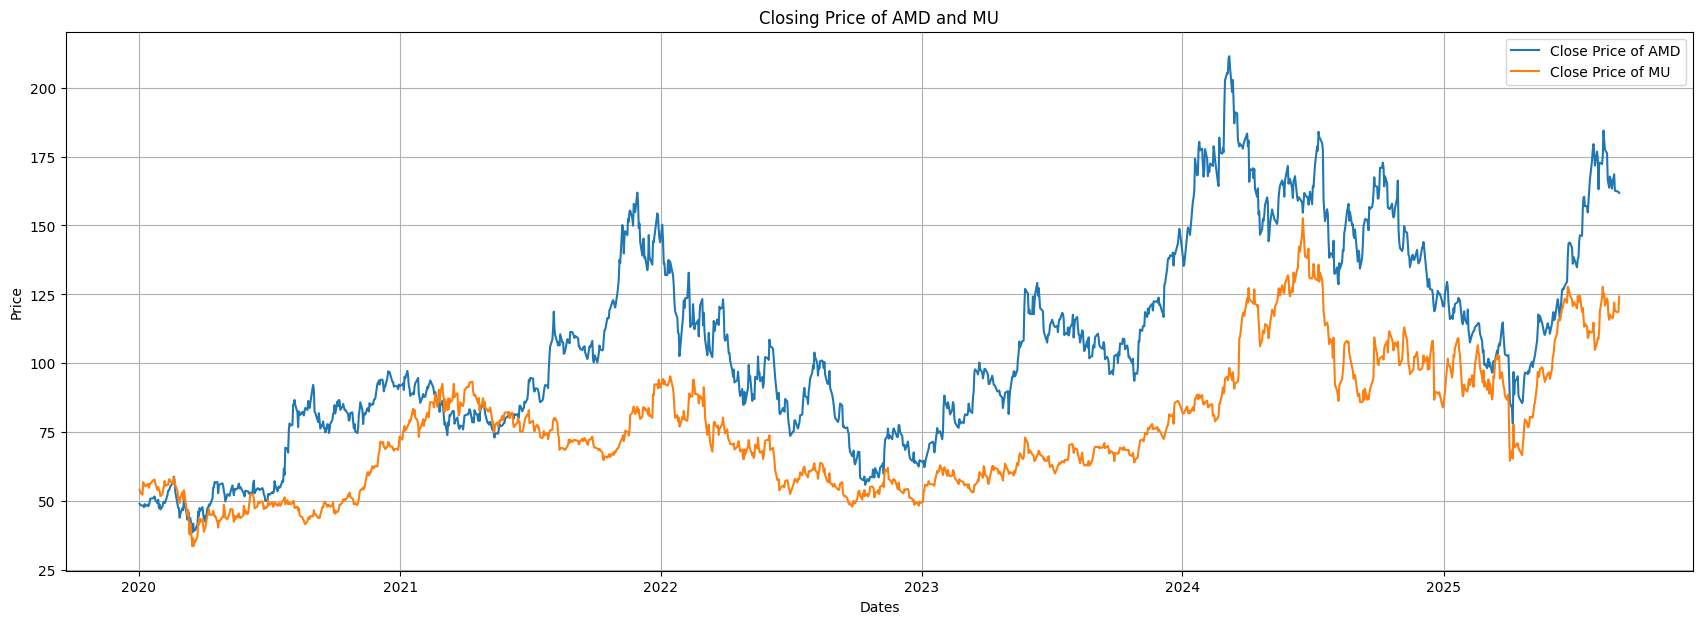

In [94]:
plt.figure(figsize=(21, 7))
plt.plot(stock1, lw=1.5, label=f"Close Price of {lowest_p_val[0]}")
plt.plot(stock2, lw=1.5, label=f"Close Price of {lowest_p_val[1]}")
plt.grid(True)
plt.legend(loc=0)

plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title(f"Closing Price of {lowest_p_val[0]} and {lowest_p_val[1]}")

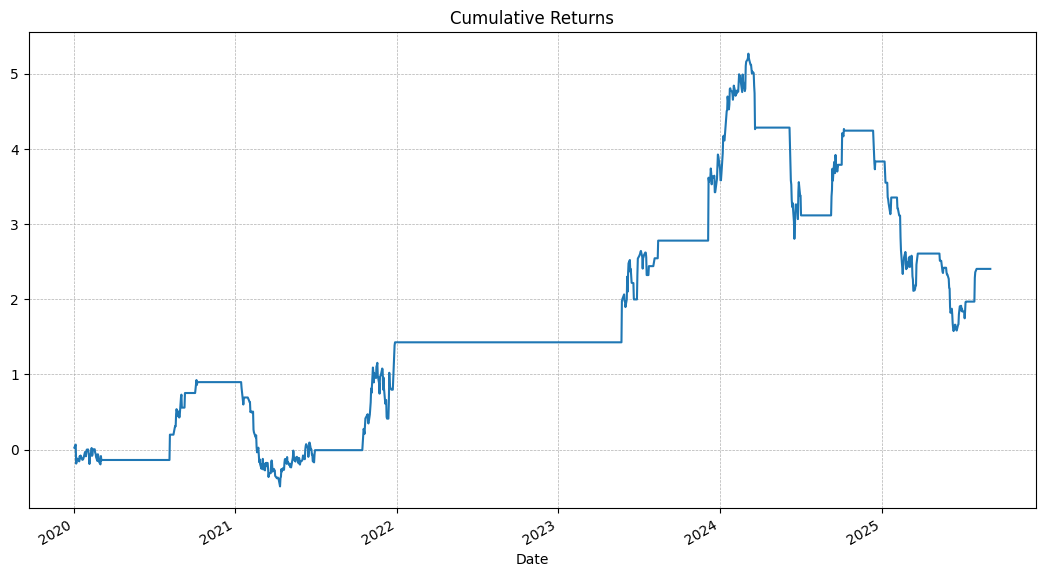

In [95]:
bt_df = pd.concat([zscore(spread), stock2 - b * stock1], axis=1)
bt_df.columns = ['signal', 'position']

bt_df['side'] = 0
bt_df.loc[bt_df['signal'] <= -1, 'side'] = 1
bt_df.loc[bt_df['signal'] >= 1, 'side'] = -1

returns = bt_df.position.pct_change() * bt_df.side
returns.cumsum().plot(figsize=(13,7), title="Cumulative Returns")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


In [96]:
df = df[[f"{lowest_p_val[0]}", f"{lowest_p_val[1]}"]]

In [97]:
df = df.join(
    spread.rename('spread'),
    how='inner'
)

In [98]:
df['next_spread'] = df['spread'].shift(-1)
df.dropna(inplace=True)

In [99]:
# Need to add dependency for train_test_split
x_test, x_train, y_test, y_train = train_test_split(
    df.drop('next_spread', axis=1).values,
    df['next_spread'].values,
    test_size=0.2,
    shuffle=False
)

In [100]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [101]:
y_pred = lr_model.predict(x_test)

In [102]:
abs_mae_lr = mean_absolute_error(y_test, y_pred)
rmse_lr = root_mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print(f"Linear Regression Mean Absolute Error: {abs_mae_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R^2: {r2_lr:.2f}")

Linear Regression Mean Absolute Error: 1.71
Linear Regression RMSE: 2.37
Linear Regression R^2: 0.98


In [103]:
# Checking for overfitting
act_val = lr_model.score(x_train, y_train)
pred_val = lr_model.score(x_test, y_test)
print(f"r2 score for training set: {act_val:.2f}")
print(f"r2 score for test set: {pred_val:.2f}")

r2 score for training set: 0.94
r2 score for test set: 0.98


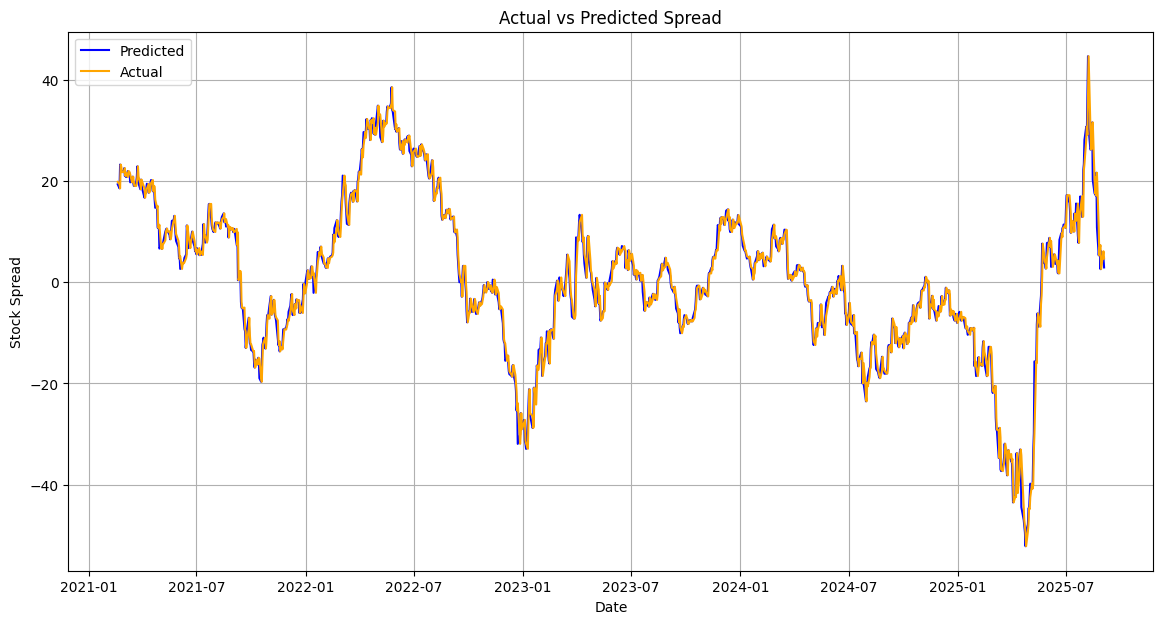

In [104]:
plt.figure(figsize=(14, 7))

# Get the dates from the original DataFrame
test_dates = df.index[-len(y_test):]

plt.plot(test_dates, y_test, label='Predicted', color='blue')
plt.plot(test_dates, spread[:y_test.shape[0]], label='Actual', color='orange')
plt.title('Actual vs Predicted Spread')
plt.xlabel('Date')
plt.ylabel('Stock Spread')
plt.legend()
plt.grid()

Text(0, 0.5, 'Predicted Values')

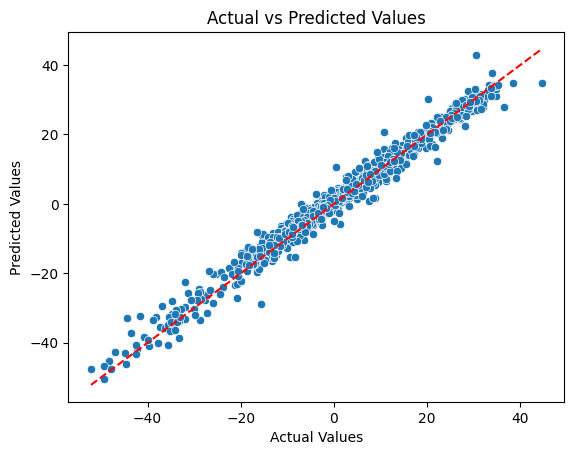

In [105]:
act_val = lr_model.score(x_train, y_train)
predict_val = lr_model.score(x_test, y_test)
sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x = np.linspace(y_test.min(), y_test.max(), 100), 
             y = np.linspace(y_test.min(), y_test.max(), 100), 
             color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Residuals')

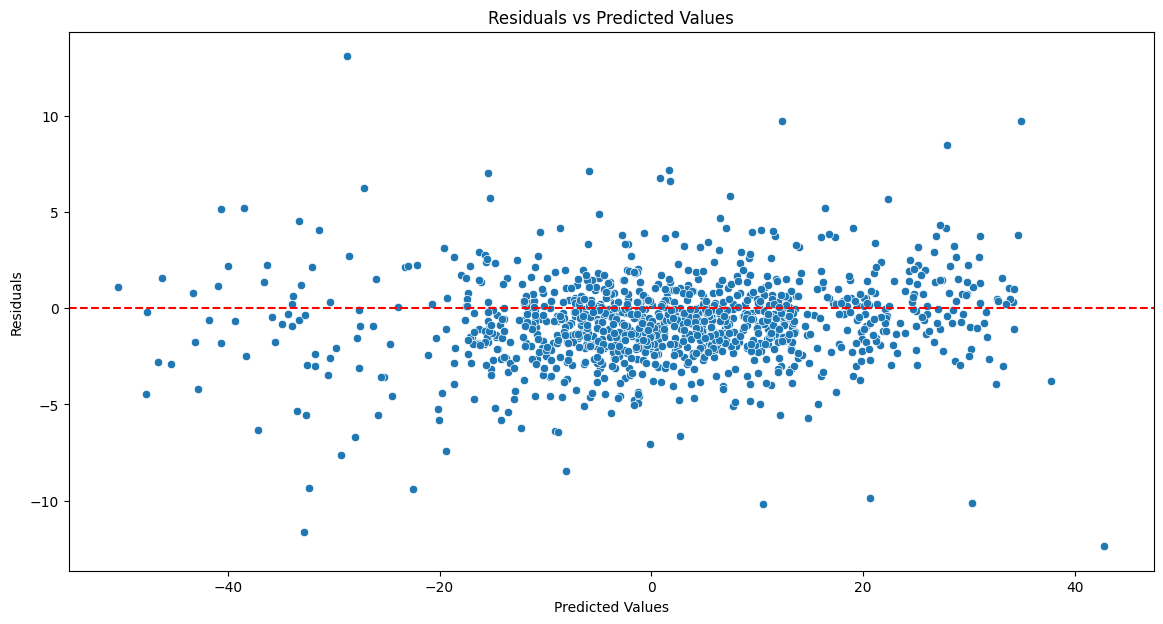

In [106]:
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

<Figure size 1400x700 with 0 Axes>

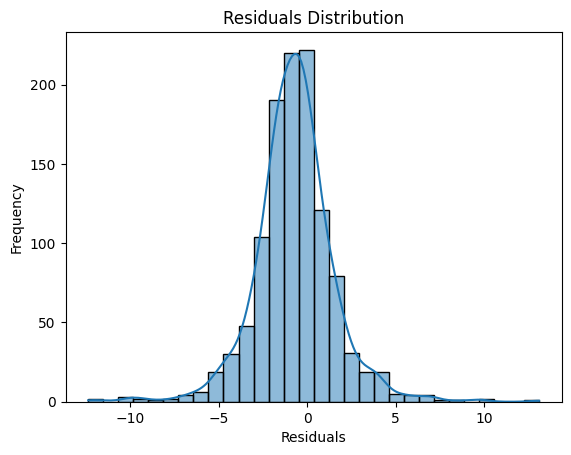

<Figure size 1400x700 with 0 Axes>

In [107]:
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.figure(figsize=(14, 7))


Text(0, 0.5, 'Sample Quantiles')

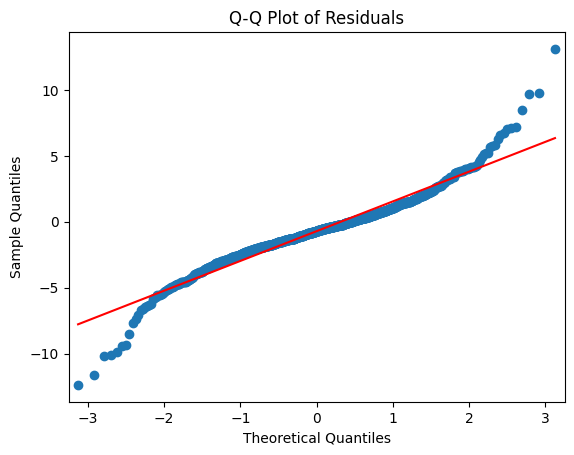

In [108]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

In [109]:
# Instantiate the IB class and connect to IBKR broker
nest_asyncio.apply()

# Connect to IB Gateway
ib = IB()
ib.connect('127.0.0.1', 4002, clientId=random.randint(1, 99))

# Connect to IB TWS
# ib = IB()
# ib.connect('127.0.0.1', 7497, clientId = random.randint(1,99)) # Using port 7497 for PAPER trading
# ib.connect('127.0.0.1', 7496, clientId = random.randint(1,99)) # Using port 7496 for LIVE trading

<IB connected to 127.0.0.1:4002 clientId=51>

In [110]:
# Create a function to buy stock
def buy_stock(ticker: str):
        
        # Checking the account balance
        acct_bal = float(ib.accountSummary()[9].value)
        
        stock = Stock(
            symbol = ticker, 
            exchange = 'SMART', 
            currency = 'USD'
        )
        
        # User should determine the amount to purchase
        purchase_amount = acct_bal * 0.1  # Example: 10% of account balance

        action = Order(
            action = 'BUY', 
            totalQuantity = round(purchase_amount.item()), 
            orderType = 'MKT',  
            tif = 'GTC', 
            outsideRth = True
        ) 
        
        order = ib.placeOrder(stock, action)

        while True:
            ib.waitOnUpdate() # Wait on any new update(s) to arrive from the network.

In [111]:
# Function to sell stock
def sell_stock(ticker: str):
        
        stock = Stock(
            symbol = ticker, 
            exchange = 'SMART', 
            currency = 'USD'
        )

        # Getting the latest price of the stock
        ticker_price = yf.Download(ticker, period='1d')['Close'].iloc[-1]  

        # Getting the amount of stock bought
        amount_bought = ib.positions().position

        sell_amount = ticker_price * amount_bought * hedge_ratio  # Adjusting sell amount based on hedge ratio

        action = Order(
            action = 'SELL', 
            totalQuantity = round(sell_amount), 
            orderType = 'MKT',  
            tif = 'GTC', 
            outsideRth = True
        )
        
        order = ib.placeOrder(stock, action)

In [112]:
# Calculate spread boundaries using standard deviation
spread_mean = df['spread'].mean()
spread_std = df['spread'].std()

# Define upper and lower boundaries (typically 1 or 2 standard deviations), use a standard devaition of 2 for more conservative trading
upper_boundary = spread_mean + 1 * spread_std
lower_boundary = spread_mean - 1 * spread_std

print(f"Spread mean: {spread_mean:.4f}")
print(f"Spread std: {spread_std:.4f}")
print(f"Upper boundary: {upper_boundary:.4f}")
print(f"Lower boundary: {lower_boundary:.4f}")
print(f"Last prediction: {y_pred[-1]:.4f}")

# Check if the last prediction is outside the boundaries
if y_pred[-1] > upper_boundary:
    print(f"Prediction {y_pred[-1]:.4f} is above upper boundary {upper_boundary:.4f}")
    print(f"Buying {lowest_p_val[0]} stock and selling {lowest_p_val[1]} stock")
    try:
        buy_stock(lowest_p_val[0])
        sell_stock(lowest_p_val[1])
    except Exception as e:
        print(f'Error occurred: {e}')
        
elif y_pred[-1] < lower_boundary:
    print(f"Prediction {y_pred[-1]:.4f} is below lower boundary {lower_boundary:.4f}")
    print(f"Selling {lowest_p_val[0]} stock and buying {lowest_p_val[1]} stock")
    try:
        buy_stock(lowest_p_val[1])
        sell_stock(lowest_p_val[0])
    except Exception as e:
        print(f'Error occurred: {e}')
else:
    print(f"Prediction {y_pred[-1]:.4f} is within boundaries [{lower_boundary:.4f}, {upper_boundary:.4f}] - No action taken")

Spread mean: 2.2217
Spread std: 14.9971
Upper boundary: 17.2188
Lower boundary: -12.7754
Last prediction: 4.3076
Prediction 4.3076 is within boundaries [-12.7754, 17.2188] - No action taken


In [113]:
ib.disconnect()
# Disconnect from the IBKR broker
print('Disconnected from IBKR broker.')

Disconnected from IBKR broker.
